In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
#from scipy.sparse.linalg import inv
#from scipy.sparse import csc_matrix
from scipy import linalg
import time

Heatequation

$\partial_t T(x,t) = \alpha \frac{d^2 T}{dx^2}(x,t)$ 

$T_0 (0) = 273$

$T(t,0) = 273$

$T(t,1) = 400$

In [2]:
class Solution:
    def __init__(self, T0, Tleft, Tright, Ntime, Nspace, dx) -> None:
        self.solution = np.zeros((Ntime, Nspace))
        self.Ntime = Ntime
        self.Nspace = Nspace
        self.Tleft = Tleft
        self.Tright = Tright
        self.solution[0,:] = T0
        self.timestep = 0
        self.dx = dx
        self.applyRB()


    def newTime(self):
        self.timestep = self.timestep + 1
        try:
            self.solution[self.timestep, :] = self.solution[self.timestep-1, :]
        except IndexError:
            print("maximum timestep reached")
        self.applyRB()

    def applyRB(self):
        self.solution[self.timestep, 0] = self.Tleft
        self.solution[self.timestep, -1] = self.Tright

    def getVal(self, spaceiter):
        if spaceiter < 0:
            spaceiter = 0
        elif spaceiter > self.Nspace-1:
            spaceiter = self.Nspace-1
        return self.solution[self.timestep, spaceiter]

    def getPreVal(self, spaceiter):
        if spaceiter < 0:
            spaceiter = 0
        elif spaceiter > self.Nspace-1:
            spaceiter = self.Nspace-1
        return self.solution[self.timestep-1, spaceiter]

    def setVal(self, spaceiter, value):
        if spaceiter <= 0:
            pass
        elif spaceiter >= self.Nspace-1:
            pass
        else:
            self.solution[self.timestep, spaceiter] = value[0,0]

    def getTimestep(self):
        return self.solution[self.timestep, :]

    def getPreTimestep(self):
        return self.solution[self.timestep-1, :]

In [3]:
# numerical Definitions:
Ntime = 2
Nspace = 5
dx = 0.1
dt = 0.5


# physical parametrization
T1 = 273
T2 = 400
K = 0.1
sol = Solution(T1, T1, T2, Ntime, Nspace, dx)

# newton settings 
damping = 1
max_iter = 100
tol = 1e-10

# Discretization Scheme:

$\frac{T^{n+1}_i-T^n_i}{\Delta t} = \alpha \frac{T^{n+1}_{i-1}-2T^{n+1}_i + T^{n+1}_{i+1}}{\Delta x^2}$

define F such
 
$F(T) = 0$

In [4]:
def F(solution, dt, dTleft=0, dTmiddle=0, dTright=0):
    R = []
    for spaceiter in range(0, solution.Nspace):
        Tnewleft = solution.getVal(spaceiter-1) + dTleft
        Tnewright = solution.getVal(spaceiter+1) + dTright
        Tnewmiddle = solution.getVal(spaceiter) + dTmiddle
        Toldmiddle = solution.getPreVal(spaceiter) 
        R.append(K*dt * (Tnewleft-2*Tnewmiddle+Tnewright)/(solution.dx**2) - Tnewmiddle+Toldmiddle)
    R[-1] = 0
    R[0] = 0
    return np.matrix(R).transpose()

In [5]:
def JF(solution, dt):
    dT = 1e-6
    J = np.matrix(np.zeros((solution.Nspace,solution.Nspace)))
    for i in range(0, solution.Nspace):
        for j in range(0, solution.Nspace):
            if (j == i-1):
                J[i,j] = (F(solution, dt, dTleft=dT)[i,0] - F(solution, dt, dTleft=0.0)[i,0] ) / dT
            elif j == i:
                J[i,j] = (F(solution, dt, dTmiddle=dT)[i,0] - F(solution, dt, dTmiddle=0.0)[i,0] ) / dT
            elif (j == i + 1):
                J[i,j] = (F(solution, dt, dTright=dT)[i,0] - F(solution, dt, dTright=0.0)[i,0] ) / dT
            else:
                J[i,j] = 0.0
    J[:,0] = 0
    J[0,:] = 0
    J[:,-1] = 0
    J[-1,:] = 0
    J[0,0] = 1
    J[-1,-1] = 1
    return J

In [6]:
for i in range(0, Ntime-1):
    niter = 0
    error = 9e9
    print(f"Time t = {i*dt}, time step {i}")
    sol.newTime()

    while ((error > tol) and (niter <= max_iter)):   
        J = JF(sol, dt)
        f = F(sol, dt)
        update = np.matrix(linalg.solve(J, -f))
        newton_step_solution = np.matrix(sol.getTimestep().transpose()).transpose() + damping * update
        for spaceiter in range(0, sol.Nspace):
            sol.setVal(spaceiter, newton_step_solution[spaceiter])
        dx_post = np.sum( np.abs( sol.getTimestep()-sol.getPreTimestep() ))
        error = np.linalg.norm(F(sol, dt))
        niter = niter + 1
        print(f"Iteration {niter}: error: {error} tol: {tol}")

Time t = 0.0, time step 0
Iteration 1: error: 1.603221107870995e-06 tol: 1e-10
Iteration 2: error: 2.898457019905882e-13 tol: 1e-10


In [7]:
sol.solution

array([[273.        , 273.        , 273.        , 273.        ,
        400.        ],
       [273.        , 293.32650448, 317.71830986, 351.05377721,
        400.        ]])

Text(0, 0.5, 'T / K')

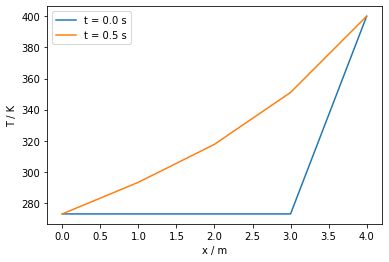

In [8]:
timesteps = [0,1]
for it in timesteps:
    plt.plot(sol.solution[it,:], label=f"t = {dt*it} s")
plt.legend()
plt.xlabel("x / m")
plt.ylabel("T / K")